In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
!pip install -q kaggle

In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/


In [ ]:
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d allen-institute-for-ai/CORD-19-research-challenge

In [ ]:
#  !unzip CORD-19-research-challenge.zip

### Imports

### General Reference words, symptoms. Publicly Available

In [ ]:
!pip install pycountry_convert 
!pip install folium
!wget https://raw.githubusercontent.com/tarunk04/COVID-19-CaseStudy-and-Predictions/master/models/model_deaths.h5
!wget https://raw.githubusercontent.com/tarunk04/COVID-19-CaseStudy-and-Predictions/master/models/model_confirmed.h5
!wget https://raw.githubusercontent.com/tarunk04/COVID-19-CaseStudy-and-Predictions/master/models/model_usa_c.h5

     |████████████████████████████████| 10.0MB 4.0MB/s 
     |████████████████████████████████| 235kB 40.5MB/s 
  Created wheel for pycountry: filename=pycountry-19.8.18-py2.py3-none-any.whl size=10627361 sha256=0aca101bc785e7a2e8396007ed4985f64a82cb2a2054a77d2414192e5ba88490
  Stored in directory: /root/.cache/pip/wheels/a2/98/bf/f0fa1c6bf8cf2cbdb750d583f84be51c2cd8272460b8b36bd3
Successfully built pycountry
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 5.1 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
--2020-05-06 07:53:03--  https://raw.githubusercontent.com/tarunk04/COVID-19-CaseStudy-and-Predictions/master/models/model_deaths.h

# Imports

In [ ]:
import pandas
import numpy
import matplotlib.pyplot as pyplot
from matplotlib import ticker 
import pycountry_convert as pc
import folium
import branca
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests

from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU
from tensorflow.keras import models
from tensorflow.keras.optimizers import RMSprop, Adam

%matplotlib inline

In [ ]:
# Retriving Dataset
dataframeConfirmed = pandas.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
dataframeDeaths = pandas.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

# Depricated
# df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
dataframeCovid19 = pandas.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
dataframeTable = pandas.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv",parse_dates=['Last_Update'])

In [ ]:
# dataframeCovid19.head()
dataframeTable.Country_Region.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

# Pre-processing

In [ ]:
dataframeConfirmed = dataframeConfirmed.rename(columns = {'Province/State':'state', 'Country/Region': 'country'})
dataframeDeaths = dataframeDeaths.rename(columns = {'Province/State':'state', 'Country/Region': 'country'})
dataframeCovid19 = dataframeCovid19.rename(columns = {'Country_Region': 'country'})
dataframeCovid19['Active'] = dataframeCovid19['Confirmed'] - dataframeCovid19['Recovered'] - dataframeCovid19['Deaths']

In [ ]:
dataframeConfirmed = dataframeConfirmed.replace(numpy.nan, '', regex = True)
dataframeDeaths = dataframeDeaths.replace(numpy.nan, '', regex = True)

In [ ]:
def plot_params(ax, axis_label = None, plt_title = None, label_size = 15, axis_fsize = 15, title_fsize = 20, scale = 'linear'):

  # Parameters
  ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
  ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
  ax.tick_params(which = 'both', width = 1, labelsize = label_size, labelcolor = 'white')
  ax.tick_params(which = 'major', length = 6)
  ax.tick_params(which = 'minor', length = 3, color = '.8')

  # Grid
  pyplot.grid(lw = 1, ls = '-', c = '.7', which = 'major')
  pyplot.grid(lw = 1, ls = '-', c = '.9', which = 'minor')

  # Title
  pyplot.title(plt_title, {'fontsize': title_fsize}, color = 'grey')

  # Y scale
  pyplot.yscale(scale)
  pyplot.minorticks_on()

  # Axes Labels
  xl = pyplot.xlabel(axis_label[0], fontsize = axis_fsize, color = 'grey')
  yl = pyplot.ylabel(axis_label[1], fontsize = axis_fsize, color = 'grey')

def visualizeCases(confirmed, deaths, continent = None, country = None, state = None, period = None, figure = None, scale = 'linear'):
  x = 0
  if figure == None:
    f = pyplot.figure(figsize = (10, 10))
    # Sub plot
    ax = f.add_subplot(111)
  else:
    f = figure[0]
    # Sub plot
    ax = f.add_subplot(figure[1], figure[2], figure[3])

  pyplot.tight_layout(pad = 10, w_pad = 5, h_pad = 5)

  stats = [confirmed, deaths]
  label = ['Confirmed', 'Deaths']

  if continent != None:
    params = ['continent', continent]
  elif country != None:
    params = ['country', country]
  else:
    params = ['All', 'All']

  color = ['darkcyan', 'crimson']
  marker_style = dict(linewidth = 3, linestyle = '-', marker = 'o', markersize = 4, markerfacecolor = '#ffffff')

  for iterator, stat in enumerate(stats):
    if params[1] == 'All':
      cases = numpy.sum(numpy.asarray(stat.iloc[:, 5:]), axis = 0)[x:]
    else:
      cases = numpy.sum(numpy.asarray(stat[stat[params[0]] == params[1]].iloc[:, 5:]), axis = 0)[x:]

    date = numpy.arange(1, cases.shape[0] + 1)[x:]
    pyplot.plot(date, cases, label = label[iterator] + " (Total : " + str(cases[-1]) + ")", color = color[iterator], **marker_style)

  if params[1] == 'All' :
    totalConfirmed = numpy.sum(numpy.asarray(stats[0].iloc[:,5:]),axis = 0)[x:]
    totalDeaths = numpy.sum(numpy.asarray(stats[1].iloc[:,5:]),axis = 0)[x:]
  else :
    totalConfirmed =  numpy.sum(numpy.asarray(stats[0][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
    totalDeaths = numpy.sum(numpy.asarray(stats[1][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        
  text = "From "+stats[0].columns[5]+" to "+stats[0].columns[-1]+"\n"
  text += "Mortality rate : "+ str(int(totalDeaths[-1]/(totalConfirmed[-1])*10000)/100)+"\n"
  text += "Last 5 Days:\n"
  text += "Confirmed : " + str(totalConfirmed[-1] - totalConfirmed[-6])+"\n"
  text += "Deaths : " + str(totalDeaths[-1] - totalDeaths[-6])+"\n"
  text += "Last 24 Hours:\n"
  text += "Confirmed : " + str(totalConfirmed[-1] - totalConfirmed[-2])+"\n"
  text += "Deaths : " + str(totalDeaths[-1] - totalDeaths[-2])+"\n"
    
  pyplot.text(0.02, 0.78, text, fontsize = 15, horizontalalignment = 'left', verticalalignment = 'top', transform = ax.transAxes,bbox = dict(facecolor = 'white', alpha = 0.4))
  
  # Plot Axes Labels
  axis_label = ["Days ("+dataframeConfirmed.columns[5] + " - " + dataframeConfirmed.columns[-1]+")", "number of cases"]
  
  # Plot Parameters
  plot_params(ax, axis_label, scale = scale)
    
  # Plot Title
  if params[1] == "All" :
    pyplot.title("COVID-19 Cases World",{'fontsize':25})
  else:   
    pyplot.title("COVID-19 Cases for "+params[1] ,{'fontsize':25})
        
    # Legend Location
  l = pyplot.legend(loc= "best",fontsize = 15)
    
  if figure == None:
    pyplot.show()
        
def get_total_cases(cases, country = "All"):
  if(country == "All") :
    return numpy.sum(numpy.asarray(cases.iloc[:,5:]),axis = 0)[-1]
  else :
    return numpy.sum(numpy.asarray(cases[cases["country"] == country].iloc[:,5:]),axis = 0)[-1]
    
def get_mortality_rate(confirmed, deaths, continent = None, country = None):
  if continent != None:
    params = ["continent",continent]
  elif country != None:
    params = ["country",country]
  else :
    params = ["All", "All"]
  
  if params[1] == "All" :
    totalConfirmed = numpy.sum(numpy.asarray(confirmed.iloc[:,5:]),axis = 0)
    totalDeaths = numpy.sum(numpy.asarray(deaths.iloc[:,5:]),axis = 0)
    mortalityRate = numpy.round((totalDeaths/(totalConfirmed + 1.01)) * 100, 2)
  else :
    totalConfirmed =  numpy.sum(numpy.asarray(confirmed[confirmed[params[0]] == params[1]].iloc[:,5:]),axis = 0)
    totalDeaths = numpy.sum(numpy.asarray(deaths[deaths[params[0]] == params[1]].iloc[:,5:]),axis = 0)
    moratlityRate = numpy.round((totalDeaths/(totlaConfirmed+1.01))*100,2)
    
  return numpy.nan_to_num(moratlityRate)
def dd(date1, date2):
  return (datetime.strptime(date1,'%m/%d/%y') - datetime.strptime(date2,'%m/%d/%y')).days


out = ""#+"output/"

# General Analysis of Data

In [ ]:
dataframeCovid19.columns

Index(['country', 'Last_Update', 'Lat', 'Long_', 'Confirmed', 'Deaths',
       'Recovered', 'Active', 'Incident_Rate', 'People_Tested',
       'People_Hospitalized', 'Mortality_Rate', 'UID', 'ISO3'],
      dtype='object')

In [ ]:
dataframeCountriesCases = dataframeCovid19.copy().drop(['Lat', 'Long_', 'Last_Update'], axis = 1)
dataframeCountriesCases.index = dataframeCountriesCases.country
dataframeCountriesCases = dataframeCountriesCases.drop(['country'], axis = 1)

#### Global reported cases till date

In [ ]:
pandas.DataFrame(dataframeCountriesCases.sum()).transpose().style.background_gradient(cmap = 'Greys', axis = 1)

#### Countrywise reported cases till date

In [ ]:
dataframeCountriesCases.sort_values('Confirmed', ascending = False).style.background_gradient(cmap = 'Blues', axis = 1)

#### Top 10 countries, confirmed cases

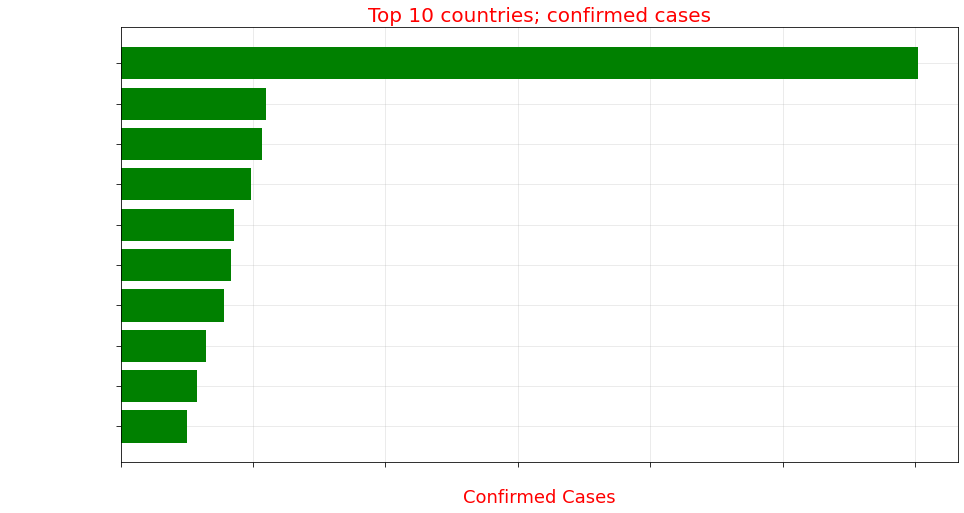

In [ ]:
f = pyplot.figure(figsize = (15, 8))
f.add_subplot(111)

pyplot.axes(axisbelow = True)
pyplot.barh(dataframeCountriesCases.sort_values('Confirmed')['Confirmed'].index[-10:],dataframeCountriesCases.sort_values('Confirmed')['Confirmed'].values[-10:], color = 'green' )
pyplot.tick_params(size = 5, labelsize = 13, labelcolor = 'white')
pyplot.xlabel('Confirmed Cases', fontsize = 18, color = 'red')
pyplot.title('Top 10 countries; confirmed cases', fontsize = 20, color = 'red')
pyplot.grid(alpha = .3)

#### Top 10 countries, death cases

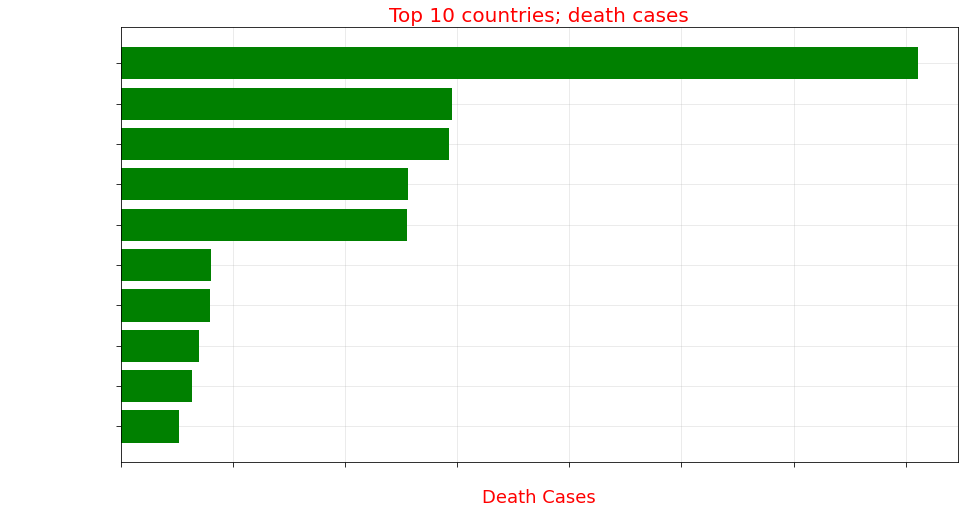

In [ ]:
f = pyplot.figure(figsize = (15, 8))
f.add_subplot(111)

pyplot.axes(axisbelow = True)
pyplot.barh(dataframeCountriesCases.sort_values('Deaths')['Deaths'].index[-10:],dataframeCountriesCases.sort_values('Deaths')['Deaths'].values[-10:], color = 'green' )
pyplot.tick_params(size = 5, labelsize = 13, labelcolor = 'white')
pyplot.xlabel('Death Cases', fontsize = 18, color = 'red')
pyplot.title('Top 10 countries; death cases', fontsize = 20, color = 'red')
pyplot.grid(alpha = .3)

#### Top 10 countries, recovered cases

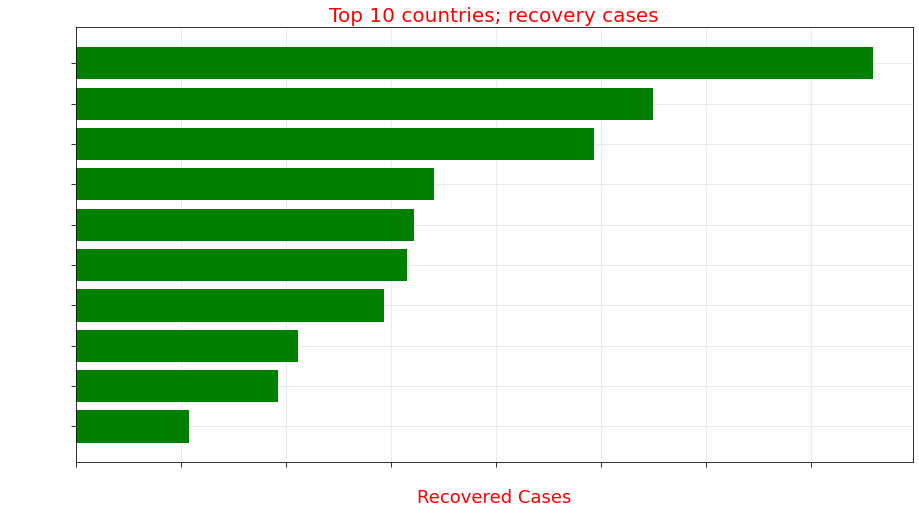

In [ ]:
f = pyplot.figure(figsize = (15, 8))
f.add_subplot(111)

pyplot.axes(axisbelow = True)
pyplot.barh(dataframeCountriesCases.sort_values('Recovered')['Recovered'].index[-10:],dataframeCountriesCases.sort_values('Recovered')['Recovered'].values[-10:], color = 'green' )
pyplot.tick_params(size = 5, labelsize = 13, labelcolor = 'white')
pyplot.xlabel('Recovered Cases', fontsize = 18, color = 'red')
pyplot.title('Top 10 countries; recovery cases', fontsize = 20, color = 'red')
pyplot.grid(alpha = .3)

In [ ]:
dataframeCountriesCases.corr().style.background_gradient(cmap = 'Reds')

/usr/local/lib/python3.6/dist-packages/pandas/io/formats/style.py:1089: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.6/dist-packages/pandas/io/formats/style.py:1090: RuntimeWarning:

All-NaN slice encountered



### Visualization on Map using Folium

In [ ]:
worldMap = folium.Map(location = [10, 0], tiles = 'cartodbpositron', zoom_start = 2, max_zoom = 6, min_zoom = 2)
for iterator in range(0, len(dataframeConfirmed)):
  folium.Circle(
      location = [dataframeConfirmed.iloc[iterator]['Lat'], dataframeConfirmed.iloc[iterator]['Long']],
      tooltip = ",<h5 style='text-align:center;font-weight: bold'>"+dataframeConfirmed.iloc[iterator]['country']+"</h5>"+
                "<div style='text-align:center;'>"+str(numpy.nan_to_num(dataframeConfirmed.iloc[iterator]['state']))+"</div>"+
                "<hr style='margin:10px;'>"+
                  "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
                    "<li>Confirmed: "+str(dataframeConfirmed.iloc[iterator, -1])+"</li>"+
                    "<li>Deaths:   "+str(dataframeDeaths.iloc[iterator, -1])+"</li>"+
                    "<li>Mortality Rate:   "+str(numpy.round(dataframeDeaths.iloc[iterator, -1]/(dataframeConfirmed.iloc[iterator, -1]+1.00001)*100,2))+"</li>"+
                  "</ul>",
      radius=(int((numpy.log(dataframeConfirmed.iloc[iterator, -1]+1.00001)))+0.2)*50000,
      color='red',
      fill_color='red',
      fill = True).add_to(worldMap)

worldMap

### Global Confirmed cases Heatmap

In [ ]:
tempDataframe = pandas.DataFrame(dataframeCountriesCases['Confirmed'])
tempDataframe = tempDataframe.reset_index()
fig = px.choropleth(tempDataframe, locations = 'country', 
                    color = numpy.log10(tempDataframe.iloc[:, -1]), 
                    hover_name = 'country', hover_data = ['Confirmed'], 
                    color_continuous_scale = px.colors.sequential.Plasma, 
                    locationmode = 'country names')
# fig.update_geos(fitbounds = 'locations', visible = False)
fig.update_layout(title_text = 'Confirmed Cases Heat Map (Log 10)')
fig.update_coloraxes(colorbar_title = 'Confirmed Cases (Log 10)', colorscale = 'Reds')
fig.show()

### Spread Progression

In [ ]:
dataframeData = dataframeTable.groupby(['Last_Update', 'Country_Region'])['Confirmed', 'Deaths'].max().reset_index()
dataframeData['Last_Update'] = pandas.to_datetime(dataframeData['Last_Update']).dt.strftime('%m%d%Y')

fig = px.scatter_geo(dataframeData, 
                     locations = 'Country_Region', 
                     locationmode = 'country names',
                     color = numpy.power(dataframeData['Confirmed'], .3),
                     size = numpy.power(dataframeData['Confirmed']+1, .3)-1,
                     hover_name = 'Country_Region', 
                     hover_data = ['Confirmed'],
                     range_color = [0, max(numpy.power(dataframeData['Confirmed'], .3))], 
                     projection = 'natural earth',
                     animation_frame = 'Last_Update',
                     color_continuous_scale = px.colors.sequential.Plasma,
                     title = 'COV-19 progression spread')
fig.update_coloraxes(colorscale = 'hot')
fig.update(layout_coloraxis_showscale = False)
fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



# Spread Analysis

1. Spread Accross Globe
2. Spreads at an individual level



---



## 1. Spread accross globe

**Number of countries affected over time**

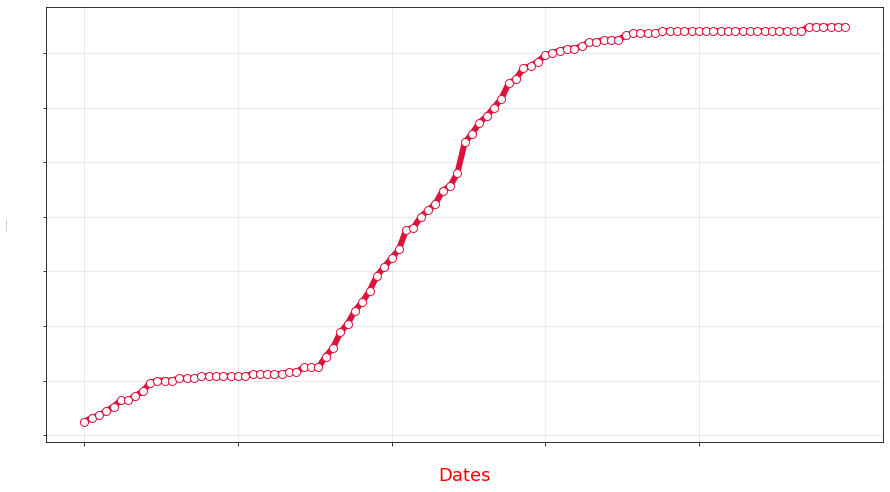

In [ ]:
caseNumsCountry = dataframeConfirmed.groupby('country').sum().drop(['Lat', 'Long'], axis = 1).apply(lambda x: x[x > 0].count(), axis =0)
dateTimes = [datetime.strptime(date, '%m/%d/%y').strftime('%d %b') for date in caseNumsCountry.index]

fig = pyplot.figure(figsize = (15, 8))
fig.add_subplot(111)
marker_style = dict(c = 'crimson', linewidth = 6, linestyle = '-', marker = 'o', markersize = 8, markerfacecolor = '#ffffff')
pyplot.plot(dateTimes, caseNumsCountry, **marker_style)
pyplot.tick_params(labelsize = 14, labelcolor = 'white')
pyplot.xticks(list(numpy.arange(0, len(dateTimes), int(len(dateTimes)/5))), dateTimes[:-1: int(len(dateTimes)/5)] + [dateTimes[-1]])

# labels
pyplot.xlabel('Dates', fontsize = 18, color = 'red')
pyplot.ylabel('Number of Countries', fontsize = 1)
pyplot.grid(alpha = .3)

pyplot.show()
pyplot.close()

### Global Spread Trends

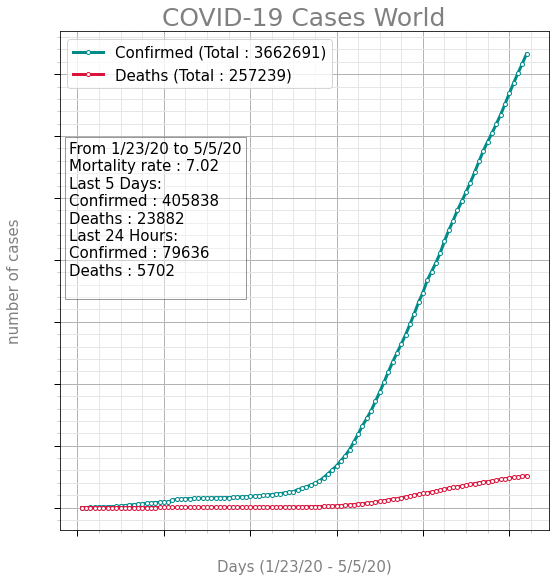

In [ ]:
cols = 1
rows = 1
fig = pyplot.figure(figsize = (10, 10*rows))
visualizeCases(dataframeConfirmed, dataframeDeaths, continent = 'All', figure = [fig, rows, cols, 1])
pyplot.show()

 ### COVID-19 Spread Trends in Few Most Affected Countries

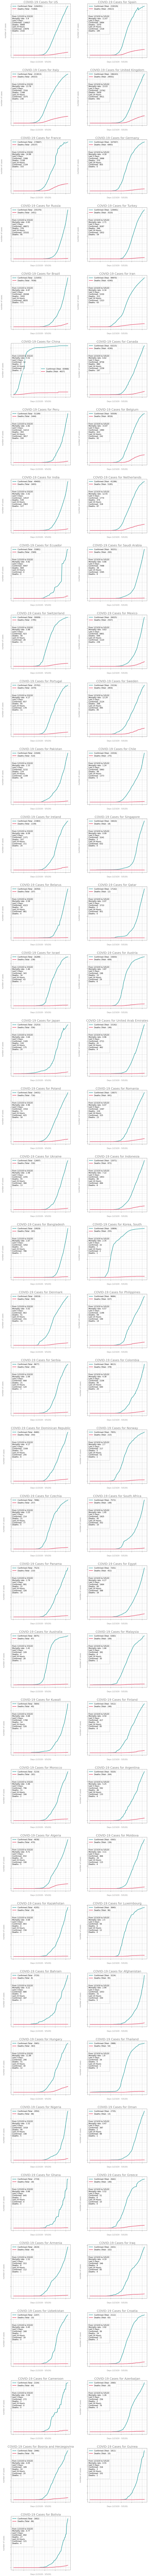

In [ ]:
dataframeCountries = dataframeConfirmed.groupby(['country']).sum()
dataframeCountries = dataframeCountries.sort_values(dataframeCountries.columns[-1], ascending = False)
countries = dataframeCountries[dataframeCountries[dataframeCountries.columns[-1]] >= 1800].index

cols = 2
rows = int(numpy.ceil(countries.shape[0]/cols))
fig = pyplot.figure(figsize = (20, 8*rows))
for iterator, country in enumerate(countries):
  visualizeCases(dataframeConfirmed, dataframeDeaths, country = country, figure = [fig, rows, cols, iterator + 1])

pyplot.show()

#### Trend Comparison of different countries vs India

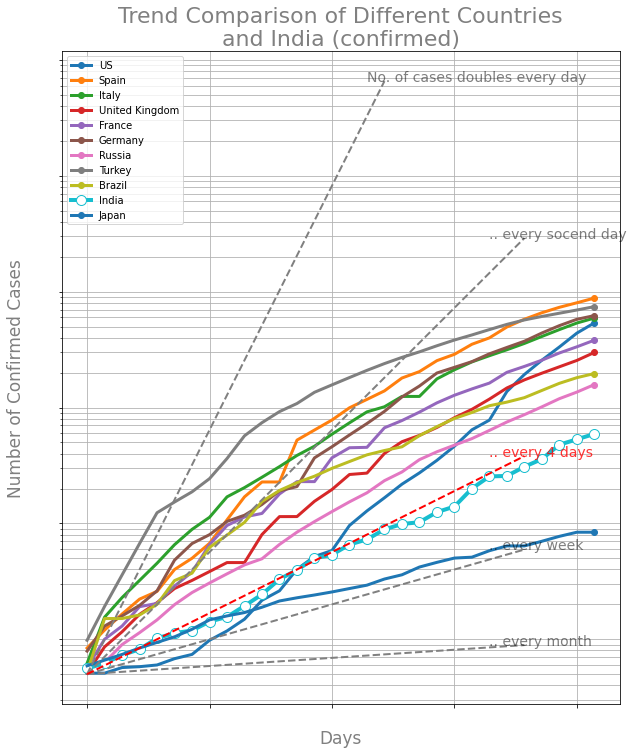

In [ ]:
temp = dataframeConfirmed.groupby('country').sum().drop(['Lat', 'Long'], axis = 1).sort_values(dataframeConfirmed.columns[-1], ascending = False)

threshold = 50
f = pyplot.figure(figsize = (10, 12))
ax = f.add_subplot(111)
for iterator, country in enumerate(temp.index):
    if iterator >= 9:
        if country != 'India' and country != 'Japan' :
            continue
    x = 30
    t = temp.loc[temp.index == country].values[0]
    t = t[t > threshold][:x]
     
    date = numpy.arange(0,len(t[:x]))
    xnew = numpy.linspace(date.min(), date.max(), 30)
    spl = make_interp_spline(date, t, k = 1)  # type: BSpline
    power_smooth = spl(xnew)
    if country != 'India':
        pyplot.plot(xnew, power_smooth, '-o', label = country, linewidth = 3, markevery = [-1])
    else:
        marker_style = dict(linewidth = 4, linestyle = '-', marker = 'o', markersize = 10, markerfacecolor = '#ffffff')
        pyplot.plot(date, t, "-.", label = country,**marker_style)

pyplot.tick_params(labelsize = 14,  labelcolor = 'white')        
pyplot.xticks(numpy.arange(0,30,7),[ 'Day ' + str(iterator) for iterator in range(30)][::7])     

# Reference lines 
x = numpy.arange(0, 18)
y = 2**(x + numpy.log2(threshold))
pyplot.plot(x, y, '--', linewidth = 2, color = 'gray')
pyplot.annotate('No. of cases doubles every day', (x[-2], y[-1]),xycoords = 'data', fontsize = 14, alpha = 0.5)

x = numpy.arange(0,26)
y = 2**(x/2+numpy.log2(threshold))
pyplot.plot(x, y, '--', linewidth = 2, color = 'gray')
pyplot.annotate('.. every socend day', (x[-3],y[-1]), xycoords = 'data', fontsize = 14, alpha = 0.5)

x = numpy.arange(0, 26)
y = 2**(x/7+numpy.log2(threshold))
pyplot.plot(x,y,'--',linewidth = 2,color = "gray")
pyplot.annotate('.. every week', (x[-3],y[-1]), xycoords = 'data', fontsize = 14, alpha = 0.5)

x = numpy.arange(0,26)
y = 2**(x/30+numpy.log2(threshold))
pyplot.plot(x, y, '--',linewidth = 2, color = 'gray')
pyplot.annotate('.. every month', (x[-3],y[-1]), xycoords = 'data', fontsize = 14, alpha = 0.5)


# India is following trend similar to doulbe the cases in 4 days but it may increase the rate 
x = numpy.arange(0, 26)
y = 2**(x/4+numpy.log2(threshold))
pyplot.plot(x,y,'--', linewidth = 2, color = 'Red')
pyplot.annotate('.. every 4 days', (x[-3],y[-1]), color = 'Red', xycoords = 'data', fontsize = 14,alpha = 0.8)

# plot Params
pyplot.xlabel('Days',fontsize = 17, color = 'grey')
pyplot.ylabel('Number of Confirmed Cases' , fontsize = 17, color = 'grey')
pyplot.title('Trend Comparison of Different Countries\n and India (confirmed) ', fontsize = 22, color = 'grey')
pyplot.legend(loc = 'upper left')
pyplot.yscale('log')
pyplot.grid(which = 'both')
pyplot.savefig(out + 'Trend Comparison with India (confirmed).png')
pyplot.show()

### World Trend

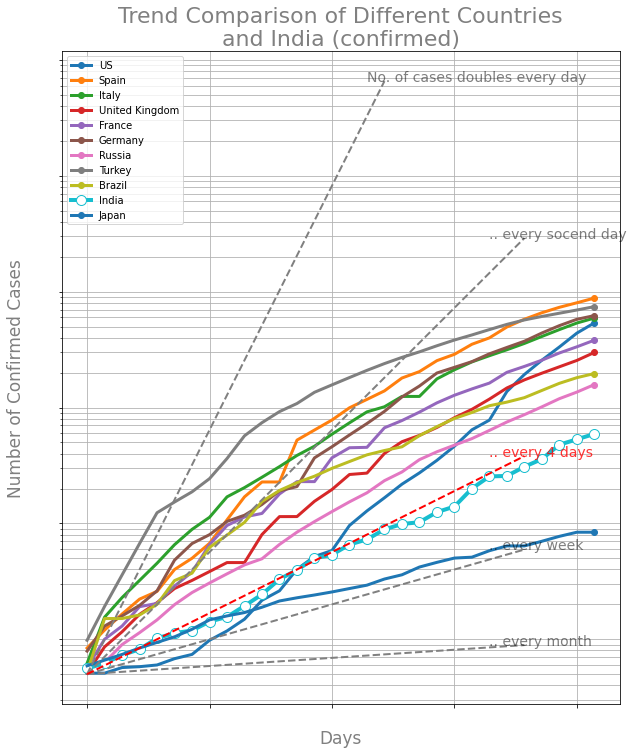

In [ ]:
temp = dataframeConfirmed.groupby('country').sum().drop(['Lat', 'Long'], axis = 1).sort_values(dataframeConfirmed.columns[-1], ascending = False)

threshold = 50
f = pyplot.figure(figsize = (10, 12))
ax = f.add_subplot(111)
for iterator, country in enumerate(temp.index):
    if iterator >= 9:
        if country != 'India' and country != 'Japan' :
            continue
    x = 30
    t = temp.loc[temp.index == country].values[0]
    t = t[t > threshold][:x]
     
    date = numpy.arange(0,len(t[:x]))
    xnew = numpy.linspace(date.min(), date.max(), 30)
    spl = make_interp_spline(date, t, k = 1)  # type: BSpline
    power_smooth = spl(xnew)
    if country != 'India':
        pyplot.plot(xnew, power_smooth, '-o', label = country, linewidth = 3, markevery = [-1])
    else:
        marker_style = dict(linewidth = 4, linestyle = '-', marker = 'o', markersize = 10, markerfacecolor = '#ffffff')
        pyplot.plot(date, t, "-.", label = country,**marker_style)

pyplot.tick_params(labelsize = 14,  labelcolor = 'white')        
pyplot.xticks(numpy.arange(0,30,7),[ 'Day ' + str(iterator) for iterator in range(30)][::7])     

# Reference lines 
x = numpy.arange(0, 18)
y = 2**(x + numpy.log2(threshold))
pyplot.plot(x, y, '--', linewidth = 2, color = 'gray')
pyplot.annotate('No. of cases doubles every day', (x[-2], y[-1]),xycoords = 'data', fontsize = 14, alpha = 0.5)

x = numpy.arange(0,26)
y = 2**(x/2+numpy.log2(threshold))
pyplot.plot(x, y, '--', linewidth = 2, color = 'gray')
pyplot.annotate('.. every socend day', (x[-3],y[-1]), xycoords = 'data', fontsize = 14, alpha = 0.5)

x = numpy.arange(0, 26)
y = 2**(x/7+numpy.log2(threshold))
pyplot.plot(x,y,'--',linewidth = 2,color = "gray")
pyplot.annotate('.. every week', (x[-3],y[-1]), xycoords = 'data', fontsize = 14, alpha = 0.5)

x = numpy.arange(0,26)
y = 2**(x/30+numpy.log2(threshold))
pyplot.plot(x, y, '--',linewidth = 2, color = 'gray')
pyplot.annotate('.. every month', (x[-3],y[-1]), xycoords = 'data', fontsize = 14, alpha = 0.5)


# India is following trend similar to doulbe the cases in 4 days but it may increase the rate 
x = numpy.arange(0, 26)
y = 2**(x/4+numpy.log2(threshold))
pyplot.plot(x,y,'--', linewidth = 2, color = 'Red')
pyplot.annotate('.. every 4 days', (x[-3],y[-1]), color = 'Red', xycoords = 'data', fontsize = 14,alpha = 0.8)

# plot Params
pyplot.xlabel('Days',fontsize = 17, color = 'grey')
pyplot.ylabel('Number of Confirmed Cases' , fontsize = 17, color = 'grey')
pyplot.title('Trend Comparison of Different Countries\n and India (confirmed) ', fontsize = 22, color = 'grey')
pyplot.legend(loc = 'upper left')
pyplot.yscale('log')
pyplot.grid(which = 'both')
pyplot.savefig(out + 'Trend Comparison with India (confirmed).png')
pyplot.show()

# Building and Fitting the model for forecasting

In [ ]:
Visible = Input(shape = (1, ))
Dense_l1 = Dense(80, name = 'Dense_l1')(Visible)
LRelu_l1 = LeakyReLU(name = 'LRelu_l1')(Dense_l1)
Dense_l2 = Dense(80,name = 'Dense_l2')(LRelu_l1)
LRelu_l2 = LeakyReLU(name = 'LRelu_l2')(Dense_l2)
Dense_l3 = Dense(1,name = 'Dense_l3')(LRelu_l2)
LRelu_l3 = LeakyReLU(name = 'Output')(Dense_l3)
model = models.Model(inputs = Visible, outputs = LRelu_l3)


model.compile(optimizer=Adam(lr = 0.001), 
              loss = 'mean_squared_error',
              metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
Dense_l1 (Dense)             (None, 80)                160       
_________________________________________________________________
LRelu_l1 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l2 (Dense)             (None, 80)                6480      
_________________________________________________________________
LRelu_l2 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l3 (Dense)             (None, 1)                 81        
_________________________________________________________________
Output (LeakyReLU)           (None, 1)                 0     

In [ ]:
y = numpy.log10(numpy.asarray(dataframeConfirmed.sum()[5:]).astype('float32'))
X = numpy.arange(1, len(y)+1)


epochs = 500
model.fit(X.reshape([y.shape[0],1]),y.reshape([X.shape[0],1]),epochs=epochs)

Epoch 1/500
4/4 [==============================] - 0s 2ms/step - loss: 8.2546 - accuracy: 0.0000e+00
Epoch 2/500
4/4 [==============================] - 0s 2ms/step - loss: 4.4981 - accuracy: 0.0000e+00
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 4.0014 - accuracy: 0.0000e+00
Epoch 4/500
4/4 [==============================] - 0s 3ms/step - loss: 4.2212 - accuracy: 0.0000e+00
Epoch 5/500
4/4 [==============================] - 0s 3ms/step - loss: 3.7836 - accuracy: 0.0000e+00
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 3.9802 - accuracy: 0.0000e+00
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 3.4142 - accuracy: 0.0000e+00
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 3.4148 - accuracy: 0.0000e+00
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 3.2103 - accuracy: 0.0000e+00
Epoch 10/500
4/4 [==============================] - 0s 3ms/step - loss: 3.3880 - accuracy: 

#### Forecasting for next 'n' days

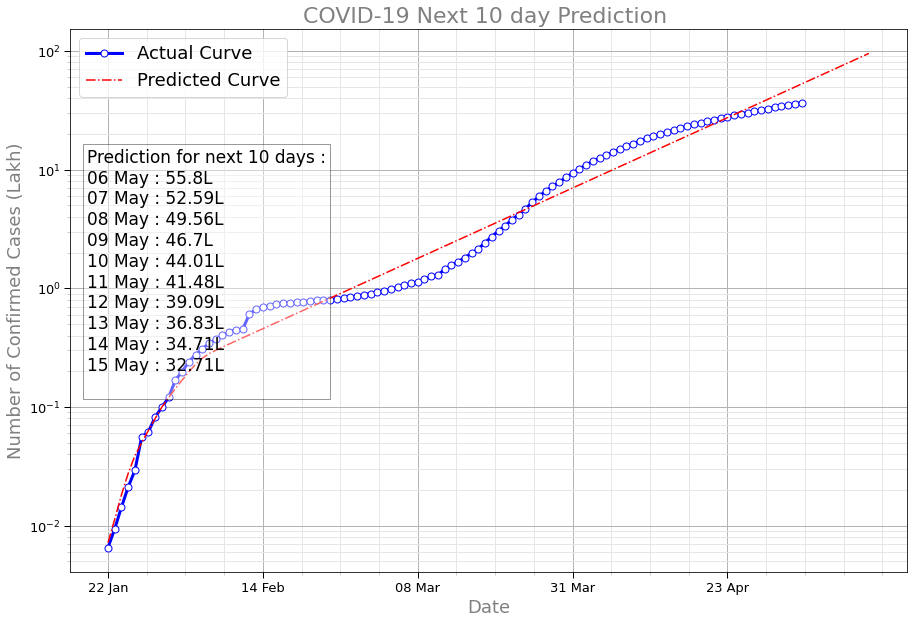

In [ ]:
predictionDays = 10
d = [datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in caseNumsCountry.index]
data = numpy.power(10, model.predict(numpy.arange(1, len(y) + predictionDays + 1)))
tempData = dataframeConfirmed.iloc[:, 5:].sum(axis = 0)
fig = pyplot.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

date = numpy.arange(0, len(tempData))

marker_style = dict(linewidth = 3, linestyle = '-', marker = 'o', markersize = 7, markerfacecolor = '#ffffff')
pyplot.plot(date, tempData/100000, '-.', color = 'blue', **marker_style, label = 'Actual Curve')

date = numpy.arange(0, len(data))
pyplot.plot(date, data/100000, '-.', color = 'red', label = 'Predicted Curve')

nextdays = [(datetime.strptime(d[-1], '%d %b') + timedelta(days = iterator)).strftime("%d %b") for iterator in range(1, predictionDays + 1)]
total = d + nextdays

text = 'Prediction for next ' + str(predictionDays) + ' days :\n'
for iterator in range(predictionDays):
    text += nextdays[iterator] + ' : ' + str(numpy.round(data[-1 * predictionDays - iterator], -3)[0]/100000) + 'L\n'

pyplot.text(.02, .78, text, fontsize = 17, horizontalalignment = 'left', verticalalignment = 'top', transform = ax.transAxes, bbox = dict(facecolor = 'white', alpha = .4))

pyplot.xticks(list(numpy.arange(0, len(total), int(len(total)/5))), d[:-1:int(len(total)/5)] + [total[-1]]) 


ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which = 'both', width = 1, labelsize = 14)
ax.tick_params(which = 'major', length = 6)
ax.tick_params(which = 'minor', length = 3, color = '0.8')


pyplot.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
pyplot.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')


pyplot.title("COVID-19 Next 10 day Prediction ",{'fontsize':22}, color = 'grey')


pyplot.xlabel('Date', fontsize = 18, color = 'grey')
pyplot.ylabel('Number of Confirmed Cases (Lakh)', fontsize = 18, color = 'grey')

pyplot.yscale('log')
pyplot.legend(fontsize = 18)
pyplot.tick_params(labelsize = 13) 
pyplot.show()

In [ ]:
startDate = '3/24/20'
sd = dd(startDate, '1/22/20')
nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days = i)).strftime("%d %b") for i in range(1, predictionDays+1)]
total = d + nextdays
dataConfirmed = numpy.power(10,model.predict(numpy.arange(1,len(y)+predictionDays+1)))
dataDeaths = numpy.power(10,model.predict(numpy.arange(1,len(y)+predictionDays+1)))
pandas.DataFrame([total[sd:],
              list(numpy.int64(numpy.round(dataConfirmed[sd:].reshape(-1)/100000,2) * 100000)),
              list(dataframeConfirmed.iloc[:,5:].sum(axis =0)[sd:]),
              list(numpy.int64(numpy.round(dataDeaths[sd:].reshape(-1)/1000, 2) * 1000)),
             list(dataframeDeaths.iloc[:,5:].sum(axis =0)[sd:])],
             ["Date","Confirmed(Predicted)","Confirmed(Actual)","Deaths(Predicted)","Deaths(Actual)"]
            ).transpose().set_index("Date")

Confirmed(Predicted) Confirmed(Actual) Deaths(Predicted) Deaths(Actual)
Date                                                                          
24 Mar               462000            467723            461720          21785
25 Mar               490000            529701            489950          24788
26 Mar               520000            593423            519900          28288
27 Mar               552000            660824            551680          31797
28 Mar               585000            720285            585400          35323
29 Mar               621000            782490            621190          39439
30 Mar               659000            857608            659160          44238
31 Mar               699000            932638            699450          49675
01 Apr               742000           1013458            742210          55817
02 Apr               788000           1095876            787590          61812
03 Apr               836000           1176059            835720          67981
04 Apr               886999           1249737            886810          73076
05 Apr               941000           1321427            941020          78767
06 Apr               999000           1396438            998530          86662
07 Apr              1060000           1480200           1059580          93354
08 Apr              1124000           1565538           1124340         100882
09 Apr              1193000           1657929           1193070         108113
10 Apr              1266000           1736025           1266010         114146
11 Apr              1343000           1835164           1343400         119853
12 Apr              1426000           1905192           1425520         125561
13 Apr              1513000           1975581           1512640         132439
14 Apr              1605000           2055506           1605120         140658
15 Apr              1703000           2151872           1703240         147946
16 Apr              1807000           2239723           1807350         156804
17 Apr              1918000           2317339           1917840         163214
18 Apr              2035000           2400894           2035070         167773
19 Apr              2159000           2471847           2159470         173098
20 Apr              2291000           2549175           2291480         180237
21 Apr              2432000           2624741           2431550         186914
22 Apr              2580000           2708547           2580170         193667
23 Apr              2738000           2795875           2737910         199999
24 Apr              2905000           2881140           2905290         206187
25 Apr              3083000           2955033           3082870         209900
26 Apr              3271000           3023722           3271300         214484
27 Apr              3471000           3097190           3471260         220799
28 Apr              3683000           3172287           3683460         227665
29 Apr              3909000           3256853           3908620         233357
30 Apr              4147999           3343777           4147540         238619
01 May              4401000           3427343           4401090         243808
02 May              4670000           3506729           4670150         247470
03 May              4956000           3583055           4955560         251537
04 May              5259000           3662691           5258580         257239
05 May              5580000              None           5579950           None
06 May              5921000              None           5921070           None
07 May              6283000              None           6282970           None
08 May              6667000              None           6667090           None
09 May              7075000              None           7074610           None
10 May              7506999              None           7507040           None
11 May              7966000              None           7

# Covid Cases in India

In [ ]:
indiaData = requests.get('https://api.rootnet.in/covid19-in/unofficial/covid19india.org/statewise').json()
dataframeIndia = pandas.io.json.json_normalize(indiaData['data']['statewise'])
dataframeIndia = dataframeIndia.set_index("state")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [ ]:
dataframeIndia

confirmed  recovered  deaths  active
state                                                                         
Maharashtra                                   15525       2819     617   12089
Gujarat                                        6245       1381     368    4496
Delhi                                          5104       1468      64    3572
Tamil Nadu                                     4058       1485      33    2540
Rajasthan                                      3193       1536      90    1567
Madhya Pradesh                                 3049       1000     176    1873
Uttar Pradesh                                  2880        987      56    1837
Andhra Pradesh                                 1777        729      36    1012
Punjab                                         1451        133      25    1293
West Bengal                                    1344        264     140     940
Telangana                                      1096        628      29     439
Jammu and Kashmir                               741        320       8     413
Karnataka                                       692        345      29     317
Haryana                                         548        256       6     286
Bihar                                           536        158       4     374
Kerala                                          503        462       4      37
Odisha                                          177         60       2     115
Jharkhand                                       125         33       3      89
Chandigarh                                      119         21       1      97
Uttarakhand                                      61         39       1      21
Chhattisgarh                                     59         36       0      23
Assam                                            45         33       1      11
Ladakh                                           42         17       0      25
Himachal Pradesh                                 42         34       3       2
Andaman and Nicobar Islands                      33         32       0       1
Tripura                                          42          2       0      40
Meghalaya                                        12         10       1       1
Puducherry                                        9          6       0       3
Goa                                               7          7       0       0
Manipur                                           2          2       0       0
Mizoram                                           1          1       0       0
Arunachal Pradesh                                 1          1       0       0
Nagaland                                          0          0       0       0
Dadra and Nagar Haveli and Daman and Diu          1          0       0       1
Daman and Diu                                     0          0       0       0
Lakshadweep                                       0          0       0       0
Sikkim                                            0          0       0       0